# Artificial Intelligence - Unsupervised Coursework Advances

## Author: Santiago Cartagena Agudelo

## Date: March 23th 2023

### Imports

In [1]:
# Importing required libraries

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy.spatial.distance import cdist
from itertools import product
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Creating toy dataset

def create_mixture(n_of_mixtures, mean_change=1):
    sigma = [[15, 2], [2, 15]]
    data = np.random.multivariate_normal(mean = [1, 1], cov = sigma, size = 100)
    for i in range(1, n_of_mixtures):
        aux = np.random.multivariate_normal(mean = np.dot([1, 1], i*mean_change), cov = sigma, size = 100)
        data = np.concatenate((data, aux), axis=0)
    return pd.DataFrame(data, columns = ["x", "y"])

<Figure size 720x720 with 0 Axes>

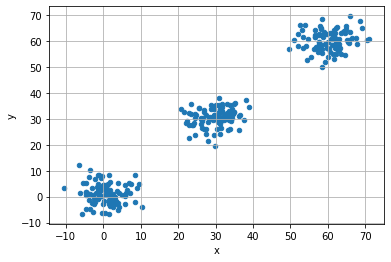

In [3]:
# Plotting toy dataset

# Create figure object and set size
fig = plt.figure(figsize=(10, 10))

# Initializing toy dataset based on the previos method
data = create_mixture(3, mean_change=30)

# Create scatter plot with grid
ax = data.plot.scatter(x="x", y="y")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid()

# Show plot
plt.show()


### Distances & Normalization

In [4]:
# 0-1 Normalization

def normalization(df):
    return (df - df.min()) / (df.max() - df.min())

In [5]:
# Euclidean Distance

def euclidean_distance(x, y):
    return np.linalg.norm( np.subtract(x, y))

In [6]:
# Manhattan Distance

def manhattan_distance(x, y):
    return np.sum(abs(e1-e2) for e1, e2 in zip(x,y))


In [7]:
# Mahalanobis Distance

def mahalanobis_distance(x, y):
    xx, yy = np.array(x), np.array(y)
    e = xx-yy
    X = np.vstack([xx,yy])
    V = np.cov(X.T)
    try:
        p = np.linalg.inv(V)
    except:
        p = np.linalg.pinv(V) # Just in case the produced matrix cannot be inverted
    D = np.sqrt(np.sum(np.dot(e,p) * e))
    return D

In [8]:
# Cosine Distance

def cosine_distance(x, y):
    norm_x = np.sum(xi ** 2 for xi in x) ** 0.5
    norm_y = np.sum(yi ** 2 for yi in y) ** 0.5
    return 1 - (np.dot(x,y) / (norm_x * norm_y))

### Train-Test Split

In [9]:
# Method for splitting data

def split_data(df, val = True):
    train = df.sample(frac=0.8)
    test = df.drop(train.index)
    if val == True:
        validation = train.sample(frac = 0.25) # 100*20/80 = 20%
        train = train.drop(validation.index) 
        return train, test, validation
    return train, test
train, test, validation = split_data(normalization(data))

## Clustering techniques from (Hammouda,2000)

### Mountain Function Algorithm

In [10]:
# Assigning each point to a cluster based on its proximity to the corresponding cluster center

def calculate_membership(X, C, distance = "euclidean"):
    D = cdist(X, C, distance)
    return np.argmin(D, axis=1)

# Calculating the density function of each point

def density_function(v, x, param, distance_func):
    return np.exp(-cdist([v], [x], distance_func) ** 2 / (2 * param ** 2))

# Calculating the mountain function for a given point and a data set

def mountain_function(X, v, sigma, distance_func):
    return np.sum([density_function(v, x, sigma, distance_func) for x in X])

# Updating mountain function after a cluster center has been selected

def update_mountain(V, M, mc, c, sigma, beta, distance_func):
    for i, _ in enumerate(M):
        M[i] -= mc * density_function(V[i], c, beta, distance_func)
    return M

def mountain(X, distance_func = "euclidean", num_c=2, num_div=1, sigma=1.2, beta=1.2):
    if isinstance(X, pd.DataFrame):
        X = X.values
    dimensions = np.linspace(X.max(axis=0), X.min(axis=0), num_div).T
    V = list(product(*dimensions))
    M = [mountain_function(X, v, sigma, distance_func) for v in V]
    C = []
    for i in range(num_c):
        max_pos = np.argmax(M)
        c, mc, =  V[max_pos], M[max_pos]
        M = update_mountain(V, M, mc, c, sigma, beta, distance_func)
        C.append(c)
    M = calculate_membership(X, C, distance_func)
    return np.array(C), M

<Axes: xlabel='x', ylabel='y'>

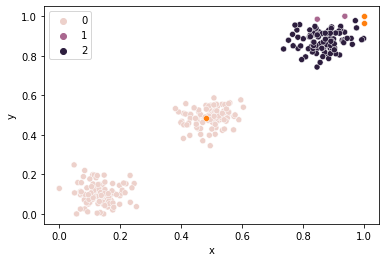

In [11]:
# Plotting results for mountain algorithm

data_normalized = normalization(data)
C, M = mountain(data_normalized, num_c=3, num_div=30)
sns.scatterplot(x = "x", y = "y", hue = M, data = data_normalized)
sns.scatterplot(x = C[:, 0], y = C[:, 1])

### Subtractive Algorithm

In [12]:
# Calculates the density of a point x with respect to a centroid v

def density_function(x, v, denominator, distance_func):
    return np.exp(-distance_func(x, v) ** 2 / denominator)

# Computes the subtraction value for a data set X and a centroid v

def substraction_function(X, v, denominator, distance_func):
    return np.sum([density_function(x, v, denominator, distance_func) for x in X])

# Computes the subtraction vector for a data set X and a radius of influence value ra

def calculate_substraction_vector(X, ra, distance_func):
    return [substraction_function(X, x, denominator=(ra / 2) ** 2, distance_func= distance_func) for x in X]

# Select the first centroid for the algorithm

def select_first_center(M, V):
    return V[np.argmax(M)]

# Updates the subtraction vector M after selecting a centroid

def update_substraction(X, M, c, rb, distance_func):
    M_c = np.max(M)
    for i, _ in enumerate(M):
        M[i] -= M_c * density_function(X[i], c, denominator=(rb / 2) ** 2, distance_func=distance_func)
    return M

# Assign each point in X to its corresponding cluster

def calculate_membership( X, C, distance = "euclidean"):
    D = cdist(X, C, distance)
    return np.argmin(D, axis=1)

def substract(X, distance_func, num_c=2, num_div=1, ra=6, rb=None):
    if isinstance(X, pd.DataFrame):
        X = X.values
    if not rb:
        rb = 1.5 * ra
    M = calculate_substraction_vector(X, ra, distance_func)
    C = []
    for i in range(num_c):
        c = select_first_center(M, X)
        M = update_substraction(X, M, c, rb, distance_func)
        C.append(c)
    M = calculate_membership(X, C)
    return np.array(C), M

<Axes: xlabel='x', ylabel='y'>

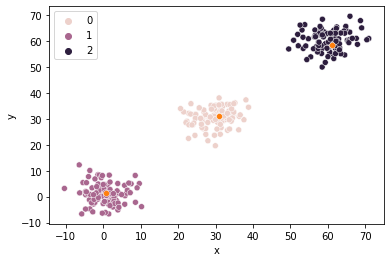

In [13]:
C, M = substract(data,  euclidean_distance, num_c=3, num_div=400)
sns.scatterplot(x = "x", y = "y", hue = M, data = data)
sns.scatterplot(x = C[:, 0], y = C[:, 1])

### K-Means Algorithm

In [14]:
def kmeans(X ,k=3, distance = "euclidean", max_iterations=5000):
    if isinstance(X, pd.DataFrame):
        X = X.values
    idx = np.random.choice(len(X), k, replace=False) 
    centroids = X[idx, :]
    P = np.argmin(cdist(X, centroids,distance), axis=1)
    for _ in range(max_iterations):
        centroids = np.vstack([X[P==i,:].mean(axis=0) for i in range(k)])
        tmp = np.argmin(cdist(X, centroids, distance),axis=1)
        if np.array_equal(P, tmp): # break tolerance
            break
        P = tmp
    return P, centroids

<Axes: xlabel='x', ylabel='y'>

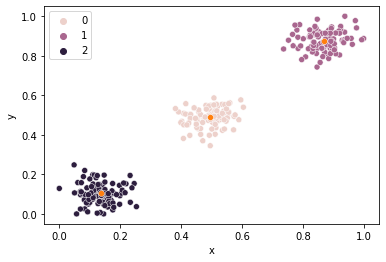

In [15]:
label, C = kmeans(data_normalized, k = 3, distance = "euclidean")
sns.scatterplot(x = "x", y = "y", hue = label, data = data_normalized)
sns.scatterplot(x = C[:, 0], y = C[:, 1])

### Fuzzy C-Means

In [16]:
def fuzzy_kmeans(X, m=1.1, distance = "euclidean",  num_c=2, iters=10):
    if isinstance(X, pd.DataFrame):
        X = X.values
    n,_ = X.shape
    U = np.random.uniform( size=( num_c, n ) ) 
    U /= np.sum(U, axis=0)
    for ite in range(iters):
        Um = U ** m
        C = np.array([ np.sum(X * u_m.reshape(-1,1), axis=0) for u_m in Um ])
        C /= np.sum( Um, axis=1 ).reshape(-1,1)
        D = np.array( [ cdist(X, [c], distance) for c in C ] )
        U = 1 / sum( [ (D / d) ** (2 / (m-1)) for d in D ] )
    M = np.argmin( D, axis=0 ).reshape(1, -1)[0]
    return C, M

<Axes: xlabel='x', ylabel='y'>

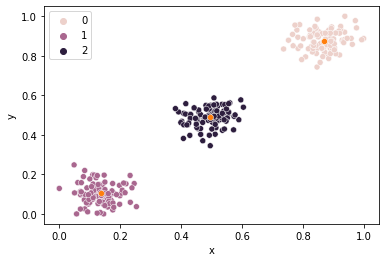

In [17]:
C, M = fuzzy_kmeans(data_normalized, m=1.1, distance = "euclidean",  num_c=3, iters=100)
sns.scatterplot(x = "x", y = "y", hue = M, data = data_normalized)
sns.scatterplot(x = C[:, 0], y = C[:, 1])